In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("valentynsichkar/traffic-signs-preprocessed")

print("Path to dataset files:", path)

100%|██████████| 4.16G/4.16G [02:19<00:00, 32.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2


In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2"

for root, dirs, files in os.walk(dataset_path):
    print(" Dirs:", dirs)
    print(" Files:", files)
    break


 Dirs: []
 Files: ['data3.pickle', 'data5.pickle', 'data7.pickle', 'mean_image_rgb.pickle', 'valid.pickle', 'data4.pickle', 'labels.pickle', 'data1.pickle', 'test.pickle', 'data0.pickle', 'label_names.csv', 'std_rgb.pickle', 'data2.pickle', 'train.pickle', 'datasets_preparing.py', 'data6.pickle', 'mean_image_gray.pickle', 'data8.pickle', 'std_gray.pickle']


In [ ]:
import pickle

dataset_path = "/root/.cache/kagglehub/datasets/valentynsichkar/traffic-signs-preprocessed/versions/2"

with open(os.path.join(dataset_path, "train.pickle"), "rb") as f:
    train_data = pickle.load(f)

with open(os.path.join(dataset_path, "test.pickle"), "rb") as f:
    test_data = pickle.load(f)

X_train = train_data['features']
y_train = train_data['labels']
X_test = test_data['features']
y_test = test_data['labels']

print("Training shape:", X_train.shape, len(y_train))
print("Test shape:", X_test.shape, len(y_test))


Training shape: (34799, 32, 32, 3) 34799
Test shape: (12630, 32, 32, 3) 12630


In [ ]:
import tensorflow as tf

X_train_resized = tf.image.resize(X_train, [96, 96]).numpy()
X_test_resized = tf.image.resize(X_test, [96, 96]).numpy()

print("New train shape:", X_train_resized.shape)
print("New test shape:", X_test_resized.shape)


New train shape: (34799, 96, 96, 3)
New test shape: (12630, 96, 96, 3)


In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = 43

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)


y_train_cat shape: (34799, 43)
y_test_cat shape: (12630, 43)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(43, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),  # learning rate أصغر في fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 1,695,915 (6.47 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_resized, y_train_cat, batch_size=32)
test_generator = test_datagen.flow(X_test_resized, y_test_cat, batch_size=3)

In [ ]:
history = model.fit(train_generator, epochs=15, validation_data=test_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 644s 575ms/step - accuracy: 0.3403 - loss: 2.4699 - val_accuracy: 0.3649 - val_loss: 2.1843
Epoch 2/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 639s 587ms/step - accuracy: 0.6397 - loss: 1.1587 - val_accuracy: 0.4941 - val_loss: 1.7168
Epoch 3/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 643s 591ms/step - accuracy: 0.7244 - loss: 0.8671 - val_accuracy: 0.5390 - val_loss: 1.6889
Epoch 4/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 607s 558ms/step - accuracy: 0.7764 - loss: 0.6988 - val_accuracy: 0.5694 - val_loss: 1.6131
Epoch 5/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 652s 599ms/step - accuracy: 0.8095 - loss: 0.5877 - val_accuracy: 0.5752 - val_loss: 1.7393
Epoch 6/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 651s 598ms/step - accuracy: 0.8413 - loss: 0.4906 - val_accuracy: 0.5892 - val_loss: 1.6114
Epoch 7/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 656s 603ms/step - accuracy: 0.8526 - loss: 0.4496 - val_accuracy: 0.5873 - val_loss: 1.7443
Epoch 8/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 662s 609ms/step - ac

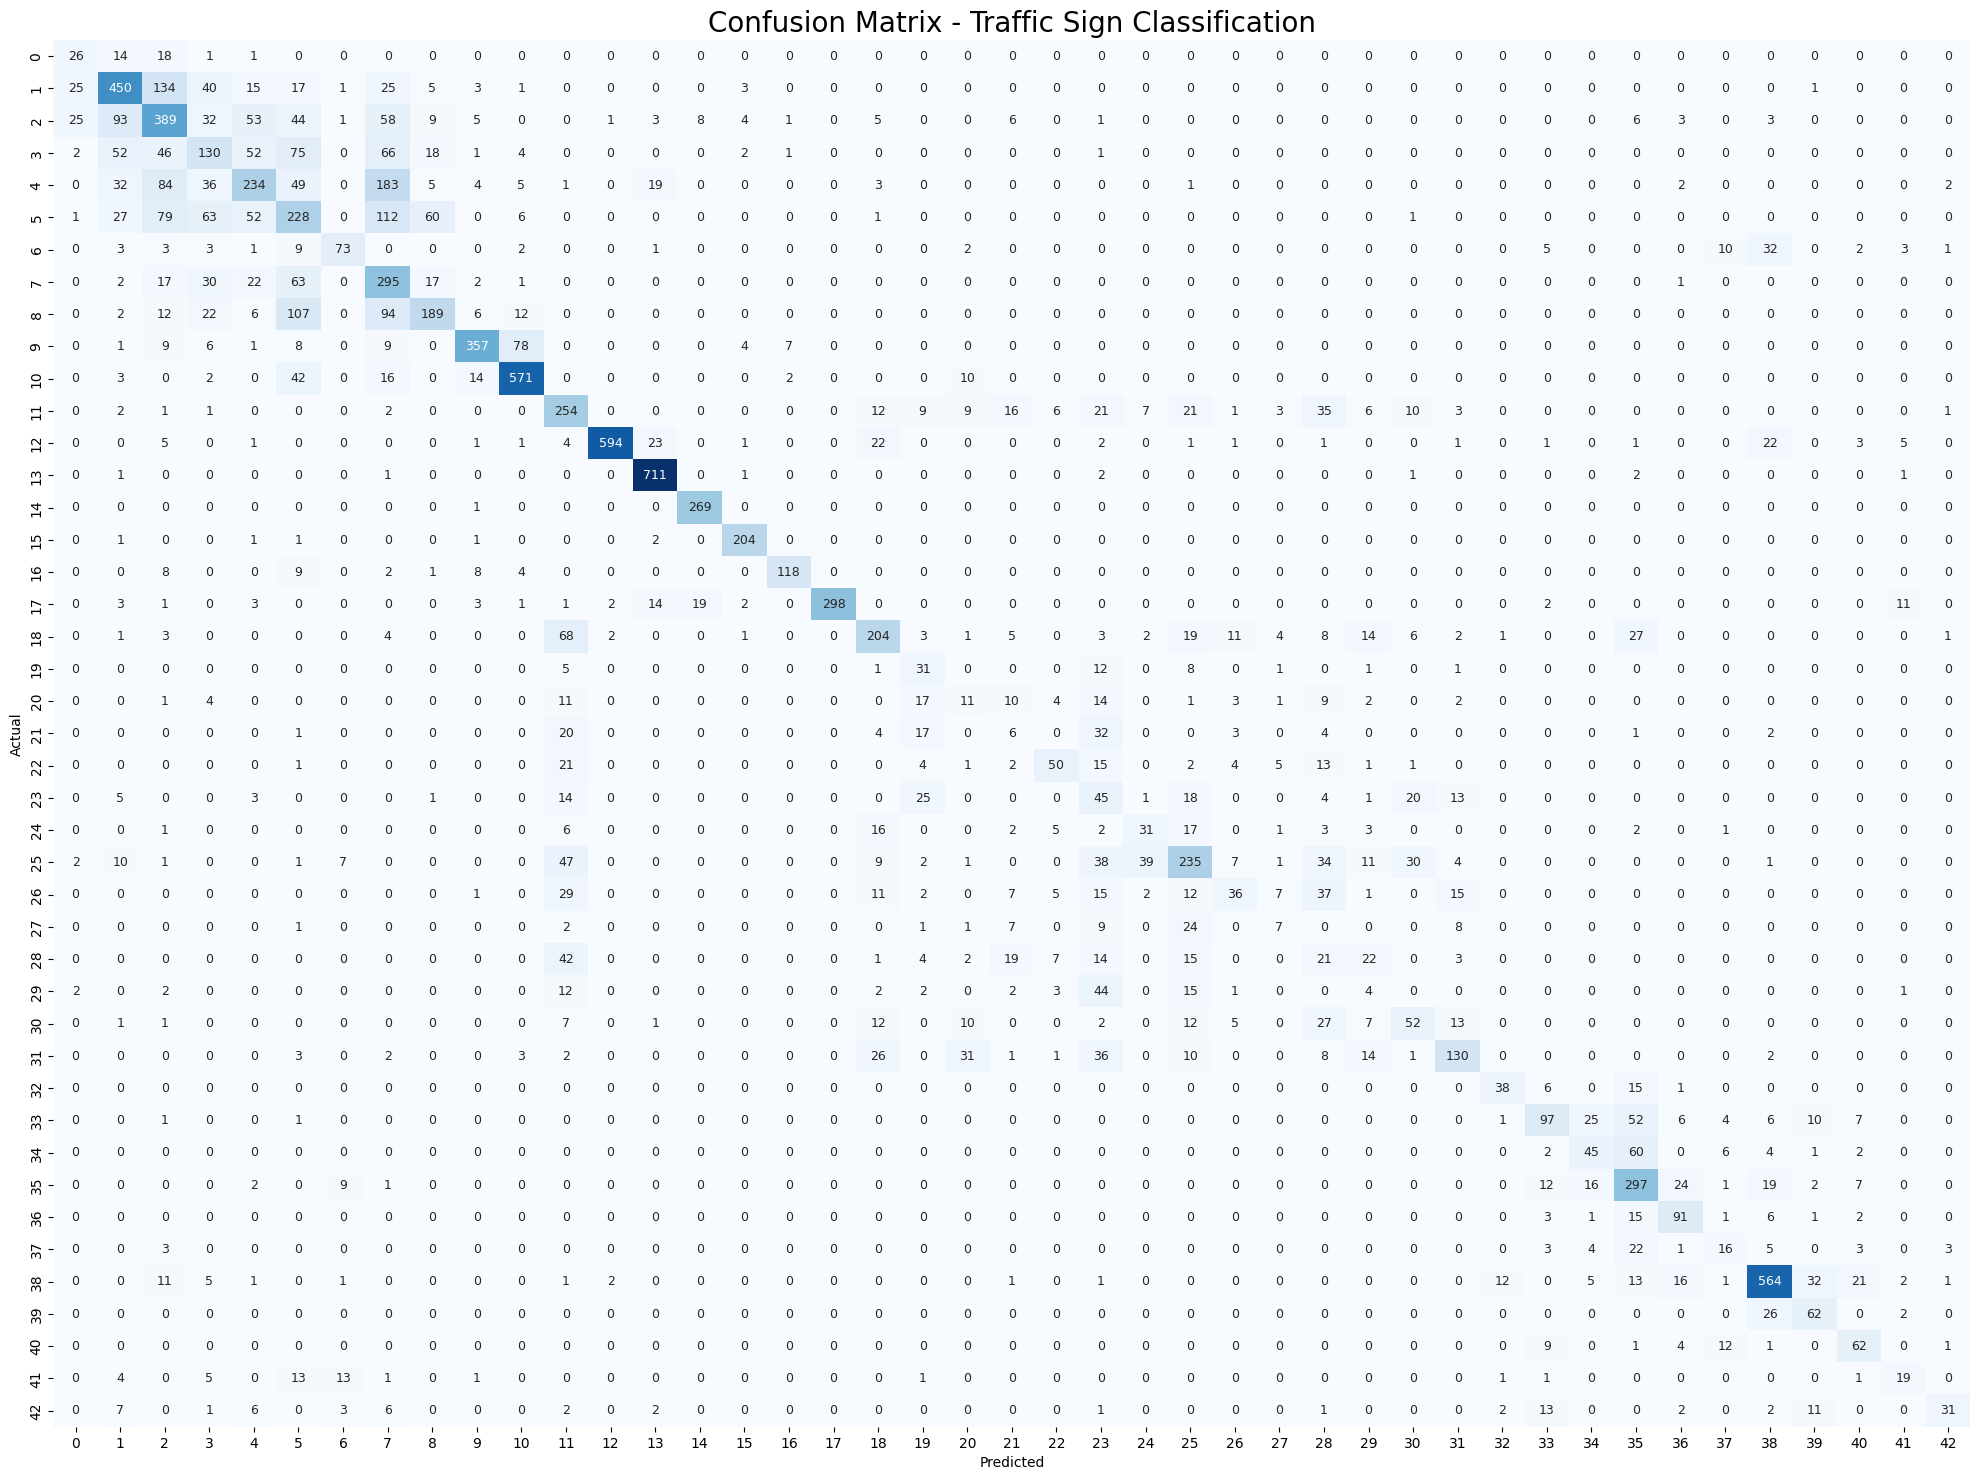

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_resized, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

cm_data = confusion_matrix(y_true_labels, y_pred_labels)

CLASS_LABELS = [str(i) for i in range(43)]

cm_df = pd.DataFrame(cm_data, columns=CLASS_LABELS, index=CLASS_LABELS)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'

plt.figure(figsize=(20, 15))
plt.title('Confusion Matrix - Traffic Sign Classification', fontsize=20)
sns.set(font_scale=1.1)
sns.heatmap(cm_df, cbar=False, cmap="Blues", annot=True, fmt='g', annot_kws={"size": 9})
plt.tight_layout()
plt.show()
